In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt_tab')
df = pd.read_csv("C:/ML/python/data/spacenews.csv",delimiter=',')

df.info()
df.duplicated().sum()
df.isna().sum()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20716 entries, 0 to 20715
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20716 non-null  object
 1   url          20716 non-null  object
 2   content      20551 non-null  object
 3   author       20716 non-null  object
 4   date         20716 non-null  object
 5   postexcerpt  18196 non-null  object
dtypes: object(6)
memory usage: 971.2+ KB


title             0
url               0
content         165
author            0
date              0
postexcerpt    2520
dtype: int64

In [2]:
df['content'] = df['content'].fillna("")

df['postexcerpt'] = df['postexcerpt'].fillna("")


In [3]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


def clean_text(text):
    
    text = str(text).lower()
    
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub("'", '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\d', '', text)
    text = re.sub(' +', ' ', text)


    return text
    
df['postexcerpt'] = df['postexcerpt'].apply(clean_text)


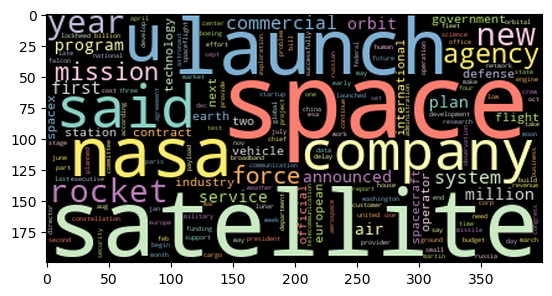

In [4]:
sw = stopwords.words("english")

from nltk.tokenize import word_tokenize


def remove_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in sw]
    return " ".join(cleaned_tokens)


df['postexcerpt'] = df['postexcerpt'].apply(remove_stopwords)

lemma = WordNetLemmatizer()


def lemmatizer(text):
    tokens = word_tokenize(text)
    lemma_tokens = [lemma.lemmatize(token) for token in tokens]
    return " ".join(lemma_tokens)

df['postexcerpt'] = df['postexcerpt'].apply(lemmatizer)

text = " ".join(i for i in df['postexcerpt'])


from wordcloud import WordCloud
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns

wc = WordCloud(colormap="Set3",collocations=False).generate(text)
plt.imshow(wc,interpolation="blackman")
plt.show()

In [5]:
from nltk import FreqDist
blob = TextBlob(text)


most_frequent_words = FreqDist(blob.words)
top_50_most_used = most_frequent_words.most_common(50)
print("top 50 most used words in space articles: ",top_50_most_used)


top 50 most used words in space articles:  [('space', 8762), ('’', 7298), ('satellite', 7184), ('launch', 4921), ('nasa', 3862), ('u', 3337), ('said', 2739), ('company', 2711), ('—', 2460), ('rocket', 2339), ('year', 2318), ('agency', 2264), ('new', 2213), ('mission', 2101), ('force', 1965), ('commercial', 1901), ('system', 1880), ('first', 1697), ('service', 1532), ('million', 1446), ('air', 1430), ('announced', 1402), ('program', 1374), ('orbit', 1370), ('plan', 1310), ('government', 1308), ('vehicle', 1287), ('spacex', 1283), ('two', 1245), ('spacecraft', 1237), ('station', 1210), ('contract', 1192), ('earth', 1144), ('“', 1106), ('technology', 1102), ('international', 1094), ('defense', 1052), ('industry', 1008), ('”', 1004), ('official', 999), ('next', 992), ('flight', 967), ('european', 951), ('operator', 947), ('communication', 927), ('may', 908), ('test', 900), ('national', 863), ('would', 845), ('one', 839)]


<Axes: ylabel='sentiment'>

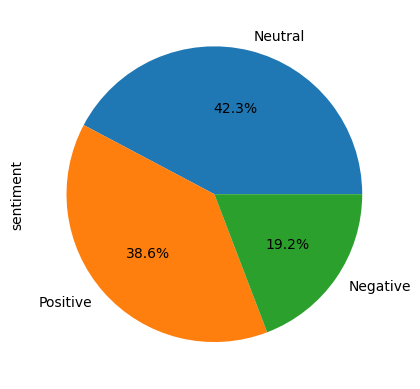

In [6]:
def polarity(text):
    return TextBlob(text).polarity



df['polarity'] = df['postexcerpt'].apply(polarity)



def sentiment(label):
    if label <0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label >= 0:
        return "Positive"


df['sentiment'] = df['polarity'].apply(sentiment)

df['sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%')



In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X = df['postexcerpt']
y = df['sentiment']
y = le.fit_transform(y)


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.15,random_state=1)


from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print(len(word_index))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length

print("Max Length of Sequences: ",max_length)

16298
Max Length of Sequences:  132


In [8]:
### padding

from tensorflow.keras.utils import pad_sequences,to_categorical


X_train = pad_sequences(X_train,max_length,padding="post")
X_test = pad_sequences(X_test,max_length,padding="post")

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Bidirectional,Dropout

RNN = Sequential()
RNN.add(Embedding(len(word_index)+1,output_dim=200,input_length=max_length))
RNN.add(SpatialDropout1D(0.5))
RNN.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
RNN.add(Dropout(0.3))
RNN.add(Dropout(0.1))
RNN.add(Dense(50))
RNN.add(Dense(3,activation='sigmoid'))
RNN.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])
history = RNN.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=(0.1))


Epoch 1/10


C:\Users\katsa\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.6212 - loss: 0.8028 - val_accuracy: 0.9177 - val_loss: 0.2662
Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.9301 - loss: 0.2224 - val_accuracy: 0.9353 - val_loss: 0.2056
Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.9687 - loss: 0.1152 - val_accuracy: 0.9461 - val_loss: 0.2094
Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9786 - loss: 0.0725 - val_accuracy: 0.9262 - val_loss: 0.2611
Epoch 5/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.9850 - loss: 0.0501 - val_accuracy: 0.9495 - val_loss: 0.2263
Epoch 6/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.9870 - loss: 0.0462 - val_accuracy: 0.9506 - val_loss: 0.2966
Epoch 7/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.9907 - loss: 0.0325 - val_accuracy: 0.9466 - val_loss: 0.3255
Epoch 8/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.9903 - loss: 0.0344 - val_accurac

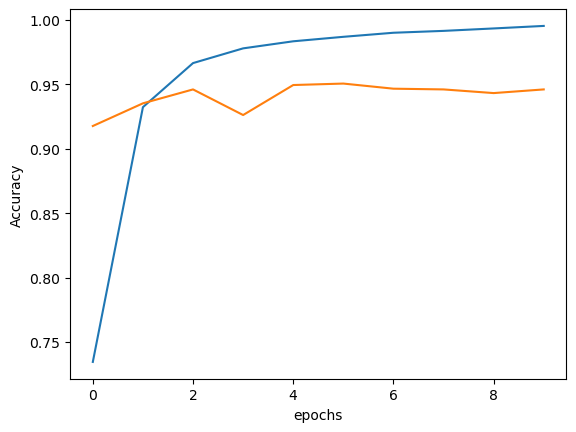

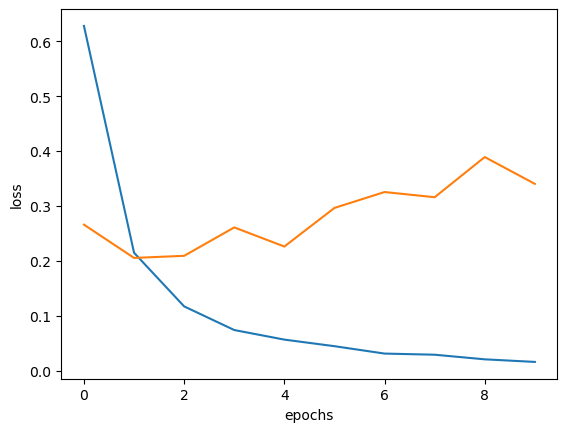

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()



In [11]:
### that was terrible, time for BERT

